# JWST Implementing Detector Effects in Simulations

WebbPSF now includes code to add detector effects into simulations. These effects come in two flavours:
- Interpixel capacitance (IPC) and Post-pixel coupling (PPC, NIRCam only). Note that IPC effects are yet to be implemented in NIRSpec and FGS simulations. 
- Charge diffusion via a simple ad hoc Gaussian convolution. 

Relevant webbpsf data files can be found here, __[webbpsf-data-1.2.0.tar.gz ](https://stsci.box.com/shared/static/34g3slaq4jidgccqj25qqo80tlk6tubl.gz)__ 

In [163]:
import webbpsf 
import numpy as np

# NIRcam Simulation with detector effects: charge difussion and IPC/PPC effects
By default detector effects are only applied to the distorted version of the detector-sampled PSF, extension 'DET_DIST'

In [157]:
nrc = webbpsf.NIRCam()
nrc.filter = 'F212N'
fov_pixels = 59
single_webbpsf_nircam = nrc.calc_psf(fov_pixels=fov_pixels)

We use a simple Gaussian convolution as a proxy of charge difussion. The value of sigma is parameterized as arcseconds for convenience. The current values of sigma are placeholders that can be change in order to better fit observations. You can acess the detector charge difussion default values from webbpsf.constants

In [158]:
print(webbpsf.constants.INSTRUMENT_DETECTOR_CHARGE_DIFFUSION_DEFAULT_PARAMETERS)

{'NIRCAM_SW': 0.0062, 'NIRCAM_LW': 0.018, 'NIRISS': 0.0202, 'FGS': 0.07, 'NIRSPEC': 0.036, 'MIRI': 0.001}


# NIRcam Simulation without detector effects: charge difussion and IPC/PPC effects

Detector effects can be deactivate via the 'charge_diffusion_sigma' and 'add_ipc' options. Similarly, the 'charge_difussion_sigma' option can be use to vary sigma to better fit observations. 

In [67]:
nrc = webbpsf.NIRCam()
nrc.filter = 'F212N'
nrc.options['charge_diffusion_sigma'] = 0
nrc.options['add_ipc'] = False
fov_pixels = 59
single_webbpsf_nircam_no_effects = nrc.calc_psf(fov_pixels=fov_pixels)


# Comparison between simulations with and without detector effects

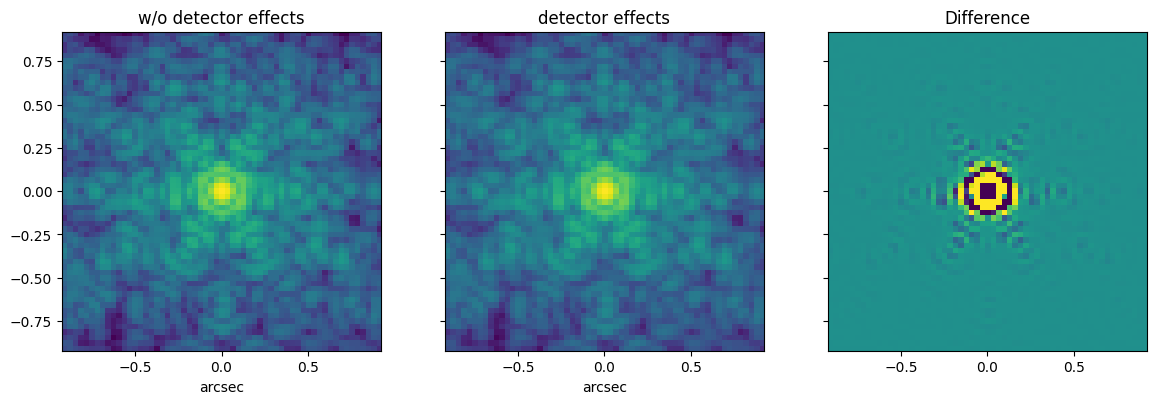

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,7), sharey=True)

webbpsf.display_psf(single_webbpsf_nircam_no_effects, ext = 3, title = 'w/o detector effects', cmap = 'viridis', ax = ax1, colorbar=False )
webbpsf.display_psf(single_webbpsf_nircam, ext = 3,  title = 'detector effects', cmap = 'viridis', ax = ax2, colorbar=False )
webbpsf.display_psf_difference(single_webbpsf_nircam,single_webbpsf_nircam_no_effects, ext1 = 3, ext2 = 3, title = 'Difference', cmap = 'viridis', ax = ax3, colorbar=False )


The above shows a comparison between simulations with and without detector effects. From the difference between simulations, it shows that our charge diffusion term is the leading term by broadening the simulated PSF.

# Comparison with observations
We are going to compare NIRISS observations and webbpsf simulations with and without detector effects. 
For this we are using the set of effective point-spread function (ePSF) presented in Mattia Libralato et al 2023 ApJ 950 101. 

Let's define a simple function to meassure FWHM for our set of observed and simulated PSFs. Note that we could also use webbpsf.measure_fwhm to acomplish the same result. 

In [160]:
def measure_fwhm(array):
    """Fit a Gaussian2D model to a PSF and return the fitted PSF
    the FWHM is x and y can be found with fitted_psf.x_fwhm, fitted_psf.y_fwhm

    Parameters
    ----------
    array : numpy.ndarray
        Array containing PSF

    Returns
    -------
    x_fwhm : float
        FWHM in x direction in units of pixels

    y_fwhm : float
        FWHM in y direction in units of pixels
    """
    from astropy.modeling import models, fitting
    yp, xp = array.shape
    y, x, = np.mgrid[:yp, :xp]
    p_init = models.Gaussian2D(amplitude = array.max(), x_mean=xp*0.5,y_mean=yp*0.5)
    fit_p = fitting.LevMarLSQFitter()
    fitted_psf = fit_p(p_init, x, y, array)
    return fitted_psf


First, we simulate and calculate the FWHM for the PSFs without detector effects for all NIRISS filters. 

In [147]:
wave_arr = np.array([])
fwhm_fun_arr_no_effects = np.array([]) 
for filters in niriss.filter_list[:-1]:
    niriss = webbpsf.NIRISS()
    niriss.filter = filters
    niriss.options['charge_diffusion_sigma'] = 0
    niriss.options['add_ipc'] = False
    fov_pixels = 25
    print('Starting {} simulation without detector effects'.format(filters))
    single_webbpsf_niriss_no_effects = niriss.calc_psf(fov_pixels=fov_pixels)
    wave_arr = np.append(wave_arr, single_webbpsf_niriss_no_effects[3].header['WAVELEN'])
    fitted_psf = measure_fwhm(single_webbpsf_niriss_no_effects[3].data)
    fwhm_fun_arr_no_effects = np.append(fwhm_fun_arr_no_effects,np.sqrt(fitted_psf.x_fwhm * fitted_psf.y_fwhm)*niriss.pixelscale)
    

Starting F090W simulation without detector effects
Starting F115W simulation without detector effects
Starting F140M simulation without detector effects
Starting F150W simulation without detector effects
Starting F158M simulation without detector effects
Starting F200W simulation without detector effects
Starting F277W simulation without detector effects
Starting F356W simulation without detector effects
Starting F380M simulation without detector effects
Starting F430M simulation without detector effects
Starting F444W simulation without detector effects
Starting F480M simulation without detector effects


Then, we perform the simulation and FWHM calculation for the PSFs with the inclusion of detector effects

In [150]:
wave_arr = np.array([])
fwhm_fun_arr = np.array([]) 
for filters in niriss.filter_list[:-1]:
    niriss = webbpsf.NIRISS()
    niriss.filter = filters
    fov_pixels = 25
    print('Starting {} simulation with detector effects'.format(filters))
    single_webbpsf_niriss = niriss.calc_psf(fov_pixels=fov_pixels)
    wave_arr = np.append(wave_arr, single_webbpsf_niriss[3].header['WAVELEN'])
    fitted_psf = measure_fwhm(single_webbpsf_niriss[3].data)
    fwhm_fun_arr = np.append(fwhm_fun_arr,np.sqrt(fitted_psf.x_fwhm * fitted_psf.y_fwhm)*niriss.pixelscale)
        

Starting F090W simulation with detector effects
Starting F115W simulation with detector effects
Starting F140M simulation with detector effects
Starting F150W simulation with detector effects
Starting F158M simulation with detector effects
Starting F200W simulation with detector effects
Starting F277W simulation with detector effects
Starting F356W simulation with detector effects
Starting F380M simulation with detector effects
Starting F430M simulation with detector effects
Starting F444W simulation with detector effects
Starting F480M simulation with detector effects


Let's take a look at the observed ePSF for NIRISS. For this you will need to download all the NIRISS ePSF into a local folder

In [143]:
from glob import glob
stdpsf = (glob('STDPSF_NIRISS/*fits'))
stdpsf.sort()

### The ePSFs are 4x oversample, corresponding to a radial distance of 12.5 real NIRISS pixels. 

In [144]:
from astropy.io import fits
from scipy import ndimage
fwhm_fun_arr_epsf = np.array([])

for fn in stdpsf:
    hd = fits.open(fn)
    eps_data = ndimage.zoom(hd[0].data[12],0.25) # the ePSF is binned down to detector-sampled 
    fitted_psf_epsf = measure_fwhm(eps_data)
    fwhm_fun_arr_epsf = np.append(fwhm_fun_arr_epsf,np.sqrt(fitted_psf_epsf.x_fwhm * fitted_psf_epsf.y_fwhm)*niriss.pixelscale)
   

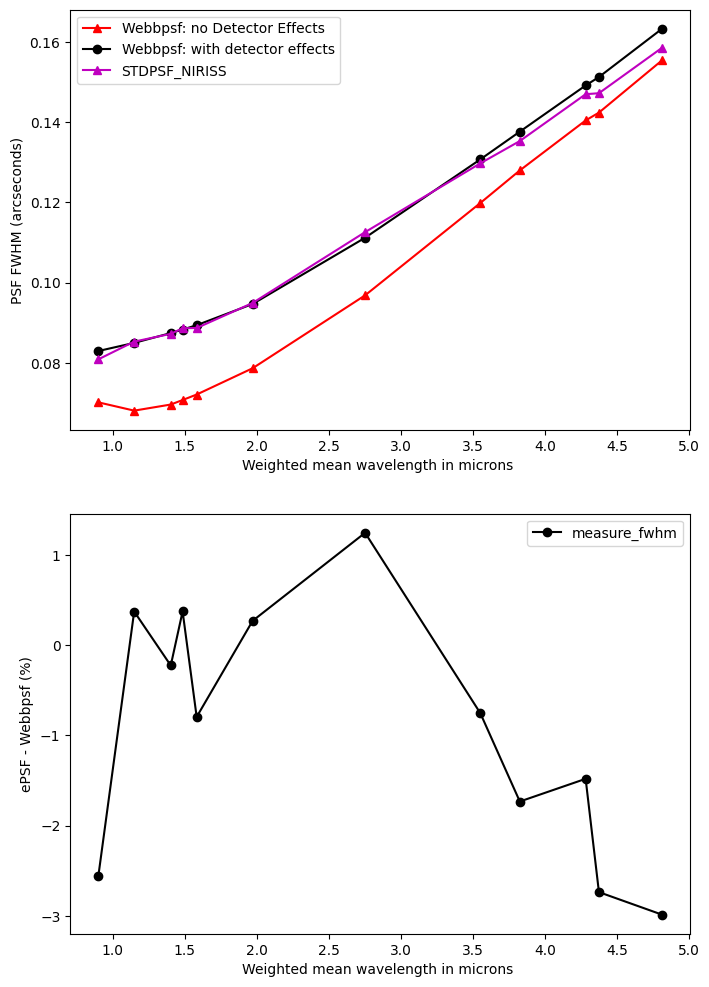

In [151]:
import matplotlib.pylab as plt
plt.figure(figsize = [8,12])
plt.subplot(2,1,1)
plt.plot(wave_arr*1e6,fwhm_fun_arr_no_effects, 'r^-' , label = 'Webbpsf: no Detector Effects')
plt.plot(wave_arr*1e6,fwhm_fun_arr, 'ko-', label = 'Webbpsf: with detector effects' )
plt.plot(wave_arr*1e6,fwhm_fun_arr_epsf, 'm^-', label = 'STDPSF_NIRISS' )
plt.xlabel('Weighted mean wavelength in microns ')
plt.ylabel('PSF FWHM (arcseconds)')
plt.legend(loc = 2)
plt.subplot(2,1,2)
plt.plot(wave_arr*1e6,(fwhm_fun_arr_epsf  - fwhm_fun_arr)*100/fwhm_fun_arr_epsf, 'ko-', label = 'measure_fwhm' )
plt.xlabel('Weighted mean wavelength in microns ')
plt.ylabel('ePSF - Webbpsf (%)')
plt.legend(loc = 0)

From the comparison above it is clear that webbpsf simulations with detector effects are a good match to observations. Note that our basic implementation for charge diffusion is wavelength-independent. However, it is clear that at longer wavelengths we should adjust sigma_charge_difussion to obtain a better fit.